In [1]:
import numpy as np 
import pandas as pd
import keras
from matplotlib import pyplot as plt
import lightgbm as lgb
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/credit-card-transactions/sd254_users.csv
/kaggle/input/credit-card-transactions/User0_credit_card_transactions.csv
/kaggle/input/credit-card-transactions/sd254_cards.csv
/kaggle/input/credit-card-transactions/credit_card_transactions-ibm_v2.csv


In [2]:
%ls /kaggle/input/credit-card-transactions

User0_credit_card_transactions.csv   sd254_cards.csv
credit_card_transactions-ibm_v2.csv  sd254_users.csv


In [3]:
data = pd.read_csv('/kaggle/input/credit-card-transactions/credit_card_transactions-ibm_v2.csv', nrows=19999999)
data

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19999994,1621,1,2017,11,4,20:59,$2.81,Swipe Transaction,-4284639674788724847,Chicago,IL,60630.0,5921,NaN,No
19999995,1621,1,2017,11,5,13:15,$10.98,Swipe Transaction,97032797689821735,Chicago,IL,60632.0,5411,NaN,No
19999996,1621,1,2017,11,5,22:53,$21.49,Swipe Transaction,5794758837639413419,Chicago,IL,60630.0,7832,NaN,No
19999997,1621,1,2017,11,6,07:12,$342.00,Swipe Transaction,3991321433720498482,Philadelphia,PA,19144.0,3405,NaN,No


In [4]:
data[data['User'] == 0]

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19958,0,4,2009,2,12,13:03,$9.71,Swipe Transaction,4060646732831064559,La Verne,CA,91750.0,5411,Technical Glitch,No
19959,0,4,2009,2,22,11:58,$27.94,Swipe Transaction,-8129520121141002186,La Verne,CA,91750.0,5211,NaN,No
19960,0,4,2009,2,24,16:53,$13.97,Swipe Transaction,5474320255037684877,Hawthorne,CA,90250.0,5912,NaN,No
19961,0,4,2009,3,29,16:30,$14.27,Swipe Transaction,4060646732831064559,La Verne,CA,91750.0,5411,NaN,No


In [5]:
data.dtypes

User                int64
Card                int64
Year                int64
Month               int64
Day                 int64
Time               object
Amount             object
Use Chip           object
Merchant Name       int64
Merchant City      object
Merchant State     object
Zip               float64
MCC                 int64
Errors?            object
Is Fraud?          object
dtype: object

## Предобработка данных. 
MCC коды показывают, где была совершена транзакция, никакого порядка(больше/меньше) в них нет, так же как и в Merchant Name, Card и Zip code, поэтому превращаем их в строки, в последствие применим encoding для этих признаков.

In [6]:
data['Zip'] = data['Zip'].fillna(0)

data['Amount'] = data['Amount'].apply(lambda s: float(s.replace("$", "")))
data['Hour'] = data['Time'].apply(lambda s: int(s.split(":")[0]))
data['Minute'] = data['Time'].apply(lambda s: int(s.split(":")[1]))

data.drop(['Time'], axis=1, inplace=True)
data['Is Fraud?'] = data['Is Fraud?'].apply(lambda s: 0 + 1 * (s != "No"))

data['Merchant Name'] = data['Merchant Name'].astype("object")
data['Card'] = data['Card'].astype("object")
data['MCC'] = data['MCC'].astype("object")
data['Zip'] = data['Zip'].astype("object")

In [7]:
for col in data.columns:
    if data[col].dtype == "object":
        data[col] = data[col].fillna("")

In [8]:
data['Merchant Name'] = data['Merchant Name'].astype("object")
data['Card'] = data['Card'].astype("object")
data['MCC'] = data['MCC'].astype("object")

data.dtypes

User                int64
Card               object
Year                int64
Month               int64
Day                 int64
Amount            float64
Use Chip           object
Merchant Name      object
Merchant City      object
Merchant State     object
Zip               float64
MCC                object
Errors?            object
Is Fraud?           int64
Hour                int64
Minute              int64
dtype: object

In [9]:
data['Is Fraud?'].sum() / len(data['Is Fraud?'])

0.001229700061485003

То есть классы сильно несбалансированны, только 0.1% от всех транзакций яляются фродовыми. В таких случаях для улучшения качества модели можно ребаллансировать классы, а также при разделении на train/test внимательно следить за соотношением классов, они должны быть равны.

In [10]:
y = data['Is Fraud?']
X = data.drop(['Is Fraud?'], axis=1)

## Encoding категориальных признаков. 
По смыслу никакого отношения порядка на данных категориальных признаках нету, поэтому стоит использовать one-hot encoding, однако так как уникальных значений слишком много, это все не влезет в память, попробуем label-encoding.

In [11]:
categorial_columns = ['Zip', 'MCC', 'Card', 'Merchant Name', 'Use Chip', 
                      'Merchant City', 'Merchant State', 'Errors?']

for feature in categorial_columns:
    encoder = sklearn.preprocessing.LabelEncoder()
    encoder.fit(X.loc[:, feature])
    X.loc[:, feature] = encoder.transform(X.loc[:, feature])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 42, stratify=y)

## Первая модель light GBM with LIME.

In [13]:
model = lgb.LGBMClassifier()

In [14]:
%time
model.fit(X_train, y_train, feature_name='auto', categorical_feature = categorial_columns)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.82 µs


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


LGBMClassifier()

In [15]:
y_pred = model.predict(X_test)

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5992622
           1       0.82      0.69      0.75      7378

    accuracy                           1.00   6000000
   macro avg       0.91      0.84      0.87   6000000
weighted avg       1.00      1.00      1.00   6000000



Отлично, обучили модель из коробки, которая дала результат f1-score в 0.75 для фродовых операций(на нефродовые смысла смотреть особо нет). В будущем попробую ресэмплировать данные для улучшения метрики.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

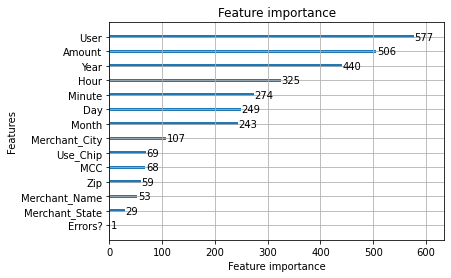

In [17]:
from lightgbm import plot_importance
plot_importance(model)

## Shap with Sklearn

In [18]:
import shap
from sklearn.ensemble import RandomForestClassifier
shap.initjs()

In [19]:
%time
my_model = RandomForestClassifier(n_estimators=15, random_state=42).fit(X_train, y_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


In [20]:
y_pred = my_model.predict(X_test)

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5992622
           1       0.99      0.57      0.72      7378

    accuracy                           1.00   6000000
   macro avg       0.99      0.78      0.86   6000000
weighted avg       1.00      1.00      1.00   6000000



Только с обработкой данных получен f1-score в 0.72, довольно неплохо, но хуже, чем дефолтная в light GBM. Сохраним предобработанные данные и обученную модель. Займемся интрепретацией.

In [22]:
data.to_csv('/kaggle/working/credit_card_transactions_prepared.csv', index=False)

In [23]:
import pickle
filename = 'sklearn_model.sav'
pickle.dump(my_model, open(filename, 'wb'))

In [24]:
loaded_model = pickle.load(open(filename, 'rb'))
print(classification_report(y_test, loaded_model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5992622
           1       0.99      0.57      0.72      7378

    accuracy                           1.00   6000000
   macro avg       0.99      0.78      0.86   6000000
weighted avg       1.00      1.00      1.00   6000000



In [25]:
y_pred.argmax(), y_pred[1430], y_test.iloc[1430]

(1430, 1, 1)

In [26]:
explainer = shap.TreeExplainer(my_model)
shap_value = explainer.shap_values(X_test[1429:1431])

### Нормальная операция

In [27]:
shap.force_plot(explainer.expected_value[1], shap_value[1][0,:], feature_names=list(X_test.columns))

### Фродовая операция

In [28]:
shap.force_plot(explainer.expected_value[1], shap_value[1][1,:], feature_names=list(X_test.columns))

Видно, что в обоих случаях(с фродовой и нормальной операцией) наибольшее значение имели feature MCC, Merchant State, Zip code и Use Chip. Все это достаточно логично, MCC код отвечает за то, где примерно была соверешена транзакция(терминал/платежная ситсема), очевидно что мошенники предпочитают примерно одни и те же точки. То же самое можно сказать про merchant(state, city, name) и zip code. Use chip определяет тип тразакции(что тоже логично, online / swipe / chip). Посмотрим на "важность" признаков в совокупности. Для усорения работы сначала посмотрим на 150 первых записей, а потом на 100 фродовых и 100 нормальных.

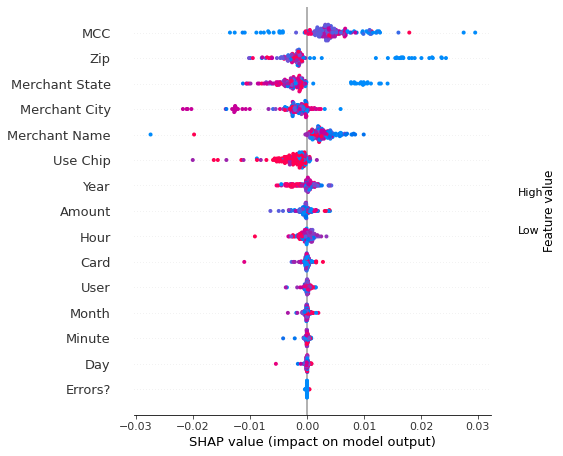

In [29]:
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(X_test[:150])
shap.summary_plot(shap_values[1], X_test[:150])

Возможно, стоит сформировать выборку с равным количеством фродовых и нефродовых операций.

In [30]:
fraud_indx = y_test[y_test == 1].index[:100]
norm_indx = y_test[y_test == 0].index[:100]
indx = fraud_indx.append(norm_indx)

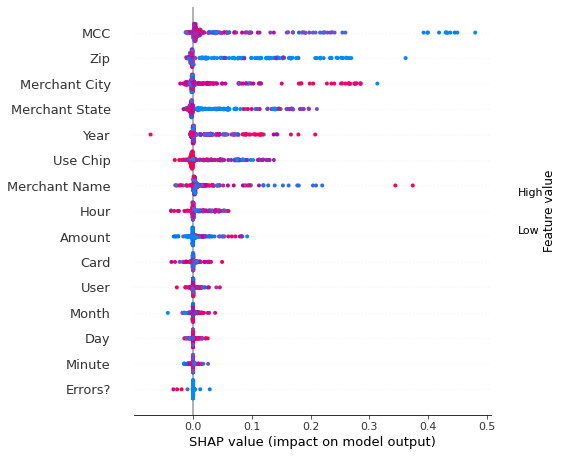

In [31]:
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(X_test.loc[indx])
shap.summary_plot(shap_values[1], X_test.loc[indx])

**Вывод** Как и ожидалось, перечисленнные выше признаки играют ключевую роль в предсказании фродовых тразакций. Удивительно, что year играет немаловажную роль, скорее всего из-за небольшого(200 записей) валидационного сета. При этом сам размер транзации тоже важен, однако не так сильно, как MCC, Merchant (State, Name, City), Zip code и Use Chip, возможно так мошенники максируются, не совершая большие покупки.

## Часть вторая: использование RNN(LSTM) и CNN для последовательности операций

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, RNN
from keras.layers.recurrent import LSTM
from tqdm import tqdm
from keras import regularizers
from keras import metrics
import time, datetime
import keras.backend as K

In [33]:
data[(data['User'] == 0) & (data['Is Fraud?'] == 1)]

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Hour,Minute
4099,0,0,2015,11,15,287.13,Online Transaction,-8194607650924472520,ONLINE,,0.0,3001,,1,12,55
4100,0,0,2015,11,15,2.41,Online Transaction,-7759074308363763111,ONLINE,,0.0,5651,,1,13,19
4101,0,0,2015,11,16,50.81,Online Transaction,-551332107213382088,ONLINE,,0.0,4411,,1,9,41
4102,0,0,2015,11,16,248.36,Online Transaction,4872340518840476610,ONLINE,,0.0,5732,,1,9,46
4103,0,0,2015,11,16,473.00,Online Transaction,-8566951830324093739,ONLINE,,0.0,3640,,1,11,20
4104,0,0,2015,11,16,144.49,Online Transaction,-3650057525483423997,ONLINE,,0.0,3007,,1,11,34
4105,0,0,2015,11,16,44.57,Online Transaction,1913477460590765860,ONLINE,,0.0,5300,,1,13,44
4106,0,0,2015,11,17,64.93,Online Transaction,4645744106416199425,ONLINE,,0.0,7996,,1,14,12
4107,0,0,2015,11,17,124.59,Online Transaction,9057735476014445185,ONLINE,,0.0,5311,,1,15,35
4108,0,0,2015,11,17,97.34,Online Transaction,5625828905483550857,ONLINE,,0.0,7922,,1,15,59


Можно заметить некоторый паттерн в поведении мошенника, за день совершается не более 3-4 покупок с небоьшими интревалами во времени и тип транзакции в основном одинаков.

In [34]:
len(data[(data['User'] == 0)])

19963

In [35]:
from collections import Counter
user_frauds = Counter(data[data['Is Fraud?'] == 1]['User'])
# user_frauds

In [36]:
data['Use Chip'].value_counts()

Swipe Transaction     12584764
Chip Transaction       5136119
Online Transaction     2279116
Name: Use Chip, dtype: int64

In [37]:
data['Merchant State'].value_counts()

                     2285372
CA                   2144007
TX                   1528788
FL                   1198156
NY                   1169684
                      ...   
Equatorial Guinea          3
Azerbaijan                 2
Togo                       2
Botswana                   1
Kiribati                   1
Name: Merchant State, Length: 212, dtype: int64

In [38]:
data['Merchant City'].value_counts()

ONLINE           2285372
Houston           206529
Los Angeles       153924
Miami             143803
Brooklyn          137186
                  ...   
Adams Run              1
Lake Waccamaw          1
Mechanicstown          1
Cummaquid              1
Fruithurst             1
Name: Merchant City, Length: 13165, dtype: int64

Здесь 13000 уникальных названий городов, что еще раз подтверждает догадку о том, что one-hot encoding здесь опасен слишком большим объемом данных.

In [39]:
data['Merchant Name'].value_counts()

 1799189980464955940    953601
-4282466774399734331    921145
 2027553650310142703    837158
-2088492411650162548    618859
-1288082279022882052    540804
                         ...  
-7288260603840999311         1
-1728799925070046749         1
-2323367266571885746         1
-5513206744377509618         1
-3289629287120173113         1
Name: Merchant Name, Length: 90151, dtype: int64

In [40]:
data['MCC'].value_counts() #MCC

5411    2316893
5499    2180555
5541    2157684
5812    1508215
5912    1127194
         ...   
3075        544
5722        526
4411        511
3144        509
5733        402
Name: MCC, Length: 109, dtype: int64

Всего примерно 20 млн записей, примерно 20000 на каждого из 1000 пользователей, у которых были фродовые операции. Хочется уменьшить данные так, чтобы сохранилась последовательность операций, при этом не потеряв фродовые операции, которых и так мало. Так как данные отсортированы по порядку пользователей, можно, например, взять 10 рандомных пользователей, которых было больше всего фродовых операций.

In [41]:
# dict(sorted(user_frauds.items(), key=lambda item: -item[1]))

`1604: 90,
 1019: 88,
 813: 85,
 897: 85,
 914: 83,
 190: 82,
 615: 81,
 1607: 81,
 1248: 79,
 413: 78`

In [42]:
# чисто для эксперимента рассмотрим историю транзакций одного user
data_ = data[data['User'] == 1604].copy()
data_[data_['Is Fraud?'] == 1]

,User,Card,Year,Month,Day,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,Hour,Minute
19779542,1604,0,2006,6,20,67.30,Swipe Transaction,-4742021959618741352,Algiers,Algeria,0.0,5912,,1,10,4
19779611,1604,0,2006,8,22,96.52,Swipe Transaction,-4282466774399734331,Banning,CA,92220.0,4829,,1,9,44
19779613,1604,0,2006,8,22,581.22,Swipe Transaction,7709322297748033061,San Diego,CA,92169.0,5932,,1,17,14
19779614,1604,0,2006,8,22,63.60,Swipe Transaction,463925858596087106,La Mesa,CA,91943.0,5300,,1,18,31
19779615,1604,0,2006,8,22,13.64,Swipe Transaction,-1288082279022882052,Indio,CA,92201.0,5499,,1,19,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19809682,1604,5,2014,3,11,52.18,Online Transaction,1913477460590765860,ONLINE,,0.0,5300,,1,6,38
19809683,1604,5,2014,3,15,223.50,Online Transaction,1715299929786123066,ONLINE,,0.0,3722,,1,2,39
19809684,1604,5,2014,3,15,-389.00,Online Transaction,1715299929786123066,ONLINE,,0.0,3722,,1,2,55
19809686,1604,5,2014,3,18,-190.00,Online Transaction,483490033258680568,ONLINE,,0.0,3504,,1,6,9


In [43]:
def get_timestamp(year, month, day, hour, minute):
    '''getting timestamp(one number) from yeqr, month, day, hour and minute'''
    return int(time.mktime((year, month, day, hour, minute, 0, 1, 48, 0)))

In [44]:
data_['Timestamp'] = data_.apply(lambda x : get_timestamp(x['Year'], x['Month'], x['Day'], x['Hour'], x['Minute']), axis=1)
data_.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1, inplace=True)

In [45]:
# соотношение фродовских операций
data_['Is Fraud?'].sum() / len(data_['Is Fraud?'])

0.002720759394177575

In [46]:
categorial_columns = ['Zip', 'MCC', 'Card', 'Merchant Name', 'Use Chip', 
                      'Merchant City', 'Merchant State', 'Errors?']

for feature in categorial_columns:
    encoder = sklearn.preprocessing.LabelEncoder()
    encoder.fit(data_.loc[:, feature])
    data_.loc[:, feature] = encoder.transform(data_.loc[:, feature])

In [47]:
# data = data[data['User'].isin([1604, 1019, 813, 897, 914, 190, 615, 1607, 1248, 413])]
# data['Timestamp'] = data.apply(lambda x : get_timestamp(x['Year'], x['Month'], x['Day'], x['Hour'], x['Minute']), axis=1)
# data.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1, inplace=True)
# data = data.drop(columns=['Year', 'Month', 'Day', 'Hour', 'Minute'])
# data = data.sort_values(['User', 'Timestamp'])
# data

Что важно, историю транзакций нужно рассматривать как временной ряд, поэтому делить как попало нельзя, для каждого user после сортировки по времени(по timestamp) насэмплируем временные отрезочки по приблизительно 10 операций, на них будем обучаться, при этом отделив часть из "будущего" для теста.

In [48]:
def resample_series(data, window=10):
    X_res = np.zeros([(data.shape[0] - window) * window, len(data.columns) - 1])
    y_res = []
    
    data = data.sort_values(['User', 'Timestamp'])
    X = data.drop('Is Fraud?', axis=1)
    y = data['Is Fraud?']
        
    for i in tqdm(range(X.shape[0]-window)):
        beg = i
        end = beg + window
        X_res[(window * i) : (window * (i+1)), :] = np.array(X.iloc[beg:end])
        y_res.append(y.iloc[end])
        
    return X_res.reshape((int(X_res.shape[0] / window), window, X_res.shape[1])), np.array(y_res)

In [49]:
# X_train, y_train = resample_series(data[data['User'].isin([1604, 1019, 813, 897, 914, 413, 615, 1607])])
# X_test, y_test = resample_series(data[data['User'].isin([1248, 190])])

In [50]:
# для одного пользователя
X_train, y_train = resample_series(data_, 20)
X_test, y_test = X_train[int(0.8 * len(X_train)):], y_train[int(0.8 * len(y_train)):]
X_train, y_train = X_train[:int(0.8 * len(X_train))], y_train[:int(0.8 * len(y_train))]

100%|██████████| 33059/33059 [00:03<00:00, 9562.13it/s]


In [51]:
print(1 / np.mean(y_train))

347.9868421052632


In [52]:
def weighted_binary_crossentropy(y_true, y_pred):
  weights = (K.abs(y_true-1) * 350) + 1.0
  bce = K.binary_crossentropy(y_true, y_pred)
  weighted_bce = K.mean(bce * weights)
  return weighted_bce

### Самая простая модель

In [53]:
model = Sequential()

model.add(LSTM(32, input_shape=X_train.shape[1:], use_bias=True, bias_initializer='zeros', 
               kernel_initializer='glorot_uniform', activation='relu'))
model.add(Dense(2, kernel_initializer='glorot_uniform', activation='softmax'))

model.compile(loss=weighted_binary_crossentropy, optimizer='adam', metrics=['accuracy'])
print(model.summary())


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                5632      
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 5,698
Trainable params: 5,698
Non-trainable params: 0
_________________________________________________________________
None


In [54]:
b = np.zeros((y_train.size, 2))
b[np.arange(y_train.size),y_train] = 1

In [55]:
model.fit(X_train, b, epochs=8, validation_split=0.2)

2022-01-09 20:39:04.579536: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/8
662/662 [==============================] - 22s 28ms/step - loss: 163480688.0000 - accuracy: 0.9852 - val_loss: 12047375.0000 - val_accuracy: 0.9970
Epoch 2/8
662/662 [==============================] - 18s 28ms/step - loss: 7278537.5000 - accuracy: 0.9972 - val_loss: 12451541.0000 - val_accuracy: 0.9970
Epoch 3/8
662/662 [==============================] - 18s 27ms/step - loss: 8196236.5000 - accuracy: 0.9972 - val_loss: 2759221.2500 - val_accuracy: 0.9970
Epoch 4/8
662/662 [==============================] - 19s 29ms/step - loss: 7823603.5000 - accuracy: 0.9972 - val_loss: 3444715.0000 - val_accuracy: 0.9970
Epoch 5/8
662/662 [==============================] - 18s 28ms/step - loss: 4362847.5000 - accuracy: 0.9972 - val_loss: 5820828.0000 - val_accuracy: 0.9970
Epoch 6/8
662/662 [==============================] - 18s 28ms/step - loss: 4733897.5000 - accuracy: 0.9972 - val_loss: 486745.5625 - val_accuracy: 0.9970
Epoch 7/8
662/662 [==============================] - 18s 28ms/step 

In [56]:
test_pred = model.predict(X_test)
print(classification_report(y_test, test_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6598
           1       0.00      0.00      0.00        14

    accuracy                           1.00      6612
   macro avg       0.50      0.50      0.50      6612
weighted avg       1.00      1.00      1.00      6612



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Результат, по факту вообще никакой, даже не смотря на взвешенную ф-ию потерь, детектить фродовские операции модель не хочет, поробуем усложнить модель
### Модель посложнее

In [57]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='prc', curve='PR'), 
]

In [58]:
model_ = Sequential()
model_.add(LSTM(128, input_shape=X_train.shape[1:], activation='relu', return_sequences=True))
model_.add(Dropout(0.2))
model_.add(LSTM(64, activation='relu', #return_sequences=True
               ))
model_.add(Dropout(0.2))
model_.add(Dense(8, kernel_initializer='glorot_uniform'))

model_.add(Dense(2, kernel_initializer='glorot_uniform', activation='softmax'))

model_.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)

model_.fit(X_train, b, epochs=2, validation_split=0.2
#            , class_weight={0 : 1, 1: 350}
          )

Epoch 1/2
662/662 [==============================] - 87s 119ms/step - loss: 3413498.7500 - accuracy: 0.9850 - precision: 0.9850 - recall: 0.9850 - prc: 0.9806 - val_loss: 425887.1250 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_prc: 0.9961
Epoch 2/2
662/662 [==============================] - 85s 128ms/step - loss: 195902.7812 - accuracy: 0.9936 - precision: 0.9936 - recall: 0.9936 - prc: 0.9916 - val_loss: 113590.4062 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_prc: 0.9961


In [59]:
test_pred = model_.predict(X_test)
print(classification_report(y_test, test_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6598
           1       0.00      0.00      0.00        14

    accuracy                           1.00      6612
   macro avg       0.50      0.50      0.50      6612
weighted avg       1.00      1.00      1.00      6612



Возможно, дело в переобучении или чем-то таком, упорно не угадываются фродовские операции на тестовыъ данных.

### Другая модель, может быть CNN
по идее она будет лучше улавливать связь своеобразных пикселей(то есть одинаковых параметров, например amount предыдущей операции со следующей).

In [60]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    
    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(2, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [61]:

model = make_model(input_shape=X_train.shape[1:])

model.compile(
    optimizer="adam",
    loss=weighted_binary_crossentropy,
    metrics=METRICS,
)

model.fit(
    X_train,
    b,
    epochs=10,
    validation_split=0.2,
    class_weight={0 : 1, 1: 350}
)

test_pred = model.predict(X_test)
print(classification_report(y_test, test_pred.argmax(axis=1)))

Epoch 1/10
662/662 [==============================] - 10s 11ms/step - loss: 19.7451 - accuracy: 0.9928 - precision: 0.9928 - recall: 0.9928 - prc: 0.9967 - val_loss: 1.8164 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_prc: 0.9975
Epoch 2/10
662/662 [==============================] - 6s 10ms/step - loss: 3.9094 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - prc: 0.9982 - val_loss: 1.8437 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_prc: 0.9961
Epoch 3/10
662/662 [==============================] - 6s 10ms/step - loss: 3.0317 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - prc: 0.9982 - val_loss: 1.6427 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_prc: 0.9961
Epoch 4/10
662/662 [==============================] - 6s 9ms/step - loss: 2.8074 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - prc: 0.9981 - val_loss: 1.2780 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_reca

In [62]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    
    gap = keras.layers.GlobalAveragePooling1D()(conv1)

    output_layer = keras.layers.Dense(2, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [63]:
model = make_model(input_shape=X_train.shape[1:])

model.compile(
    optimizer="adam",
    loss='binary_crossentropy',
    metrics=METRICS,
)

model.fit(
    X_train,
    b,
    epochs=2,
    validation_split=0.2,
#     class_weight={0 : 350, 1: 1}
)

test_pred = model.predict(X_test)
print(classification_report(y_test, test_pred.argmax(axis=1)))

Epoch 1/2
662/662 [==============================] - 5s 5ms/step - loss: 0.0844 - accuracy: 0.9901 - precision: 0.9901 - recall: 0.9901 - prc: 0.9961 - val_loss: 0.0213 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_prc: 0.9961
Epoch 2/2
662/662 [==============================] - 3s 4ms/step - loss: 0.0191 - accuracy: 0.9972 - precision: 0.9972 - recall: 0.9972 - prc: 0.9963 - val_loss: 0.0482 - val_accuracy: 0.9970 - val_precision: 0.9970 - val_recall: 0.9970 - val_prc: 0.9961
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6598
           1       0.00      0.00      0.00        14

    accuracy                           1.00      6612
   macro avg       0.50      0.50      0.50      6612
weighted avg       1.00      1.00      1.00      6612



**Выводы:**
В общем, я долго пытался, попробовал несколько разных архитектур, ф-ий активации, количество эпох, Модель стала запоминать фродовых операции на трейновых данных, однако на тесте нет, все равно я уверен, что cnn и lstm это правильный шаг в сторону решений и при достаточном времени обучения и правильной архитектуре, можно получить резуьтат не хуже, чем с помощью ансамблей деревбев.